# BidMPH v2 Monitor <br> Sao Paolo

## Imports

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [102]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [103]:
CITY_ID = 4142
CITY_NAME = 'Sao_Paolo'
ORDER_TYPE = 'auto_econom'

In [104]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [105]:
start_date = '2025-05-01'
end_date = '2025-06-29'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as Sao_Paolo_total_bids.csv


df0 ('Before')

In [106]:
start_date = '2025-05-01'
end_date = '2025-05-27'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:10+00:00 
 to 2025-05-27 23:59:59+00:00
df0 saved as Sao_Paolo_before_bids.csv


df1 ('Test')

In [107]:
start_date = '2025-05-28'
end_date = '2025-06-29'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-28 00:00:11+00:00 
 to 2025-06-02 06:41:51+00:00
df1 saved as Sao_Paolo_test_bids.csv


## Process Data

In [108]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [109]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [110]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [111]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_29178/3278834597.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')


df1

In [112]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_29178/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [113]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

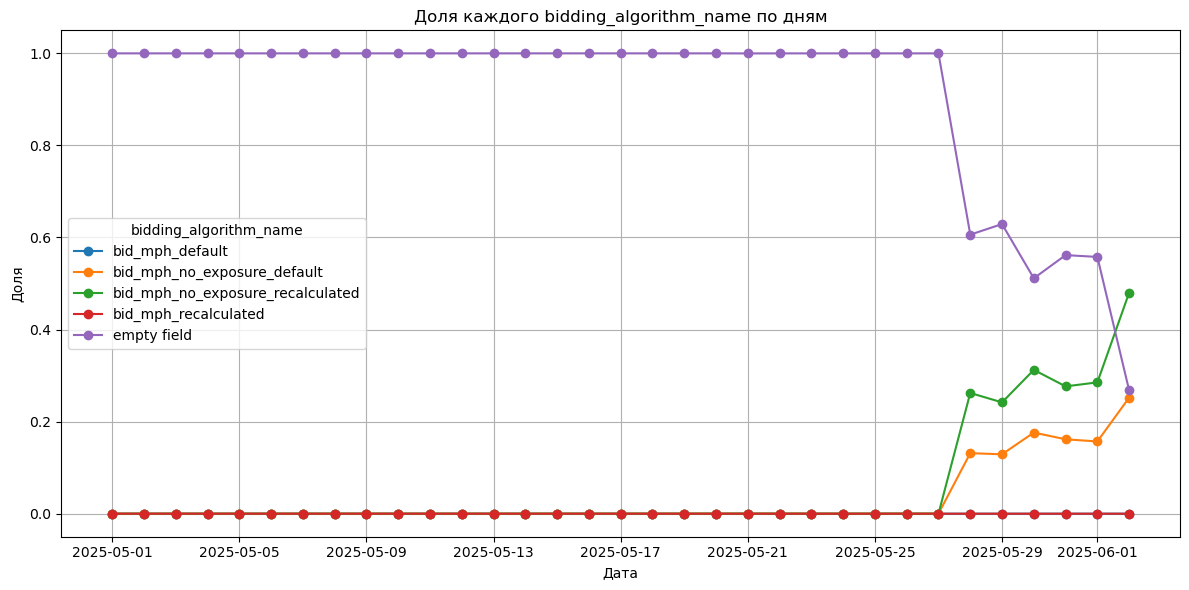

In [114]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [115]:
df0['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_default',
       'bid_mph_no_exposure_recalculated', 'bid_mph_default',
       'bid_mph_recalculated'], dtype=object)

In [116]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=4)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=4)

In [117]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_default': 0.0,
 'bid_mph_no_exposure_default': 0.0,
 'bid_mph_no_exposure_recalculated': 0.0,
 'bid_mph_recalculated': 0.0,
 'empty field': 1.0}
Максимальное кол-во шагов:
4
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 0.0001,
 'len_4': 0.9999,
 'total': 7668788}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0228,
                'share': 0.1676},
 'between_0_1': {'done_share': 0.1679,
                 'share': 0.0193},
 'between_1_2': {'done_share': 0.0956,
                 'share': 0.021},
 'between_2_3': {'done_share': 0.0484,
                 'share': 0.0162},
 'match_first': {'done_share': 0.2404,
                 'share': 0.1068},
 'match_second': {'done_share': 0.15,
                  'share': 0.1642},
 'match_sp': {'done_share': 0.4477,
              'share': 0.1884},
 'match_third': {'done_share': 0.088,
                 'share': 0.1567}}
Доли

In [118]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.20315374476384013 0.10683213566472304 0.16420065334965578 0.15673219809962147


df1

In [119]:
df1['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_recalculated',
       'bid_mph_no_exposure_default', 'bid_mph_recalculated'],
      dtype=object)

In [120]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=4)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=4)

In [121]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.1559,
 'bid_mph_no_exposure_recalculated': 0.2844,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.5597}
Максимальное кол-во шагов:
4
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 0.0001,
 'len_4': 0.9999,
 'total': 807721}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.022,
                'share': 0.1647},
 'between_0_1': {'done_share': 0.1649,
                 'share': 0.0203},
 'between_1_2': {'done_share': 0.0949,
                 'share': 0.022},
 'between_2_3': {'done_share': 0.0438,
                 'share': 0.0174},
 'match_first': {'done_share': 0.2346,
                 'share': 0.1083},
 'match_second': {'done_share': 0.144,
                  'share': 0.163},
 'match_sp': {'done_share': 0.4414,
              'share': 0.1912},
 'match_third': {'done_share': 0.0846,
                 'share': 0.1559}}
Доли совпадений с SP/

In [122]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=4)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=4)

In [123]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.1559,
 'bid_mph_no_exposure_recalculated': 0.2844,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.5597}
Максимальное кол-во шагов:
4
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.4515,
 'len_3': 0.098,
 'len_4': 0.4505,
 'total': 635312}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0425,
                'share': 0.2565},
 'between_0_1': {'done_share': 0.1673,
                 'share': 0.0223},
 'between_1_2': {'done_share': 0.0856,
                 'share': 0.0122},
 'between_2_3': {'done_share': 0.0482,
                 'share': 0.0085},
 'match_first': {'done_share': 0.2309,
                 'share': 0.1156},
 'match_second': {'done_share': 0.1504,
                  'share': 0.2023},
 'match_sp': {'done_share': 0.4407,
              'share': 0.1971},
 'match_third': {'done_share': 0.0671,
                 'share': 0.0951}}
Доли совпадений

## !

In [124]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 200
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [125]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [126]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

,213727,520851,1060506
bid_uuid,0197221a-42a0-7d91-9af0-c716a445939a,01971b5b-f2e3-7517-8a11-2bd35f2b827d,0197223e-1239-7c7f-8f8f-b35e59a30b12
etr,1685.0,1363.0,1767.0
eta,60,300,660
price_highrate_value,27.0,24.0,36.0
price_start_value,27.0,22.0,35.0
bid_price_currency,39.0,28.0,39.0
steps_recalc_default,"[29.700000000000003, 32.4, 35.1]","[24.200000000000003, 26.4, 28.6]","[38.5, 42.0, 45.5]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_default,bid_mph_no_exposure_recalculated
available_prices_currency,"[30.0, 33.0]","[22.0, 24.0, 26.0, 28.0]","[39.0, 42.0, 44.0]"
steps_real_perc,"[1.1111111111111112, 1.2222222222222223]","[1.0, 1.0909090909090908, 1.1818181818181819, ...","[1.1142857142857143, 1.2, 1.2571428571428571]"


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>

In [127]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,7,9,12,14,17,21,22,24,31,33,...,1463114,1463117,1463118,1463120,1463122,1463123,1463125,1463127,1463129,1463130
bid_uuid,01971d0f-07e4-79b1-9fba-465b027b8196,01971cf0-2650-7a25-a833-049c9480662e,01971e10-47f6-7339-9961-7abfba6fb314,01971e67-904e-7b3f-95d9-db5557a8d053,0197279b-b8ee-72e1-a570-4b6d7c5843bb,01972e30-f510-7a3f-bcff-a40c0f600532,01972e0a-7448-7a2c-b02f-ef2ac62fd96f,01972efd-4fc6-796d-b8d1-7a0865282708,01972947-f8a7-7515-bfb5-377cad395b65,01972bae-72f6-7614-a343-1eb8988fdc94,...,01972282-c721-7392-ad07-769b941be3f0,019726e6-f5b1-7771-847e-c4ed3fb16308,019720ad-1e96-718b-9576-8bcc00bb7866,01972803-9320-7862-8496-95c302a8f759,019721e4-f874-7bdf-9bdf-bee62f08cede,01972282-c019-7cd7-965a-560b21b40f38,019721e5-00e6-7bdf-a3f3-fc565a07ed71,0197203b-9834-7a00-801b-a35036e687af,01971efe-3e68-740a-8d5b-002a3fae7487,0197203b-b89f-7bf4-b318-3f1a5682839e
etr,1456.0,1663.0,1141.0,3400.0,2080.0,NaN,NaN,NaN,858.0,3476.0,...,1820.0,2299.0,1602.0,1615.0,2509.0,1820.0,2509.0,1678.0,1559.0,1678.0
eta,180,840,540,540,300,300,300,600,240,240,...,300,180,300,120,420,120,360,300,120,420
price_highrate_value,23.0,27.0,25.0,52.0,48.0,28.0,10.0,20.0,22.0,75.0,...,22.0,33.0,11.0,30.0,NaN,22.0,NaN,34.0,33.0,34.0
price_start_value,23.0,27.0,25.0,60.0,48.0,30.0,10.0,20.0,22.0,85.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
bid_price_currency,25.0,35.0,30.0,70.0,48.0,36.0,17.0,40.0,27.0,93.0,...,33.0,30.0,35.0,30.0,36.0,30.0,49.0,39.0,33.0,40.0
steps_recalc_default,"[25.3, 27.599999999999998, 29.900000000000002]","[29.700000000000003, 32.4, 35.1]","[27.500000000000004, 30.0, 32.5]","[66.0, 72.0, 78.0]","[52.800000000000004, 57.599999999999994, 62.40...","[33.0, 36.0, 39.0]","[11.0, 12.0, 13.0]","[22.0, 24.0, 26.0]","[24.200000000000003, 26.4, 28.6]","[93.50000000000001, 102.0, 110.5]",...,"[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[26.0, 28.0]","[30.0, 33.0]","[28.0, 30.0]","[66.0, 72.0, 73.0]","[53.0, 58.0]","[33.0, 36.0]","[11.0, 12.0]","[22.0, 24.0, 26.0, 27.0]","[25.0, 27.0]","[83.0, 90.0, 93.0]",...,"[33.0, 36.0]","[33.0, 36.0, 39.0, 40.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0, 39.0, 41.0]","[33.0, 36.0, 39.0, 40.0]","[33.0, 36.0, 39.0, 41.0]"
steps_real_perc,"[1.1304347826086956, 1.2173913043478262]","[1.1111111111111112, 1.2222222222222223]","[1.12, 1.2]","[1.1, 1.2, 1.2166666666666666]","[1.1041666666666667, 1.2083333333333333]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3, 1.35]","[1.1363636363636365, 1.2272727272727273]","[0.9764705882352941, 1.0588235294117647, 1.094...",...,"[1.1, 1.2]","[1.1, 1.2, 1.3, 1.3333333333333333]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3, 1.3666666666666667]","[1.1, 1.2, 1.3, 1.3333333333333333]","[1.1, 1.2, 1.3, 1.3666666666666667]"


In [128]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.974003
                                  True          0.025997
bid_mph_no_exposure_recalculated  False         0.429418
                                  True          0.570582
bid_mph_recalculated              True          1.000000
empty field                       False         0.601063
                                  True          0.398937
dtype: float64

In [129]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,1462396,353118,412691,819990,1288729
bid_uuid,01972598-a99c-7f51-9272-7462a1d7663f,019717a3-a0d6-74b1-b301-baae0c06e2d0,01971e68-36aa-7916-b78f-a16bc201a87c,019722e1-9657-7ed4-af2f-3ffb2c47bd2c,01971d5a-80d4-725e-aa24-3ed6fa3cd12e
etr,1302.0,2458.0,2427.0,605.0,365.0
eta,360,780,780,360,540
price_highrate_value,33.0,39.0,38.0,16.0,10.0
price_start_value,30.0,39.0,40.0,16.0,10.0
bid_price_currency,36.0,49.0,50.0,20.0,10.0
steps_recalc_default,"[33.0, 36.0, 39.0]","[42.900000000000006, 46.8, 50.7]","[44.0, 48.0, 52.0]","[17.6, 19.2, 20.8]","[11.0, 12.0, 13.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[33.0, 36.0, 39.0, 40.0]","[43.0, 47.0, 49.0]","[39.0, 42.0, 46.0, 48.0]","[18.0, 20.0]","[11.0, 12.0]"
steps_real_perc,"[1.1, 1.2, 1.3, 1.3333333333333333]","[1.1025641025641026, 1.205128205128205, 1.2564...","[0.975, 1.05, 1.15, 1.2]","[1.125, 1.25]","[1.1, 1.2]"


In [130]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)]['bid_uuid'].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [131]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [132]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,7,9,12,14,17,21,22,24,31,33,...,1463114,1463117,1463118,1463120,1463122,1463123,1463125,1463127,1463129,1463130
bid_uuid,01971d0f-07e4-79b1-9fba-465b027b8196,01971cf0-2650-7a25-a833-049c9480662e,01971e10-47f6-7339-9961-7abfba6fb314,01971e67-904e-7b3f-95d9-db5557a8d053,0197279b-b8ee-72e1-a570-4b6d7c5843bb,01972e30-f510-7a3f-bcff-a40c0f600532,01972e0a-7448-7a2c-b02f-ef2ac62fd96f,01972efd-4fc6-796d-b8d1-7a0865282708,01972947-f8a7-7515-bfb5-377cad395b65,01972bae-72f6-7614-a343-1eb8988fdc94,...,01972282-c721-7392-ad07-769b941be3f0,019726e6-f5b1-7771-847e-c4ed3fb16308,019720ad-1e96-718b-9576-8bcc00bb7866,01972803-9320-7862-8496-95c302a8f759,019721e4-f874-7bdf-9bdf-bee62f08cede,01972282-c019-7cd7-965a-560b21b40f38,019721e5-00e6-7bdf-a3f3-fc565a07ed71,0197203b-9834-7a00-801b-a35036e687af,01971efe-3e68-740a-8d5b-002a3fae7487,0197203b-b89f-7bf4-b318-3f1a5682839e
etr,1456.0,1663.0,1141.0,3400.0,2080.0,NaN,NaN,NaN,858.0,3476.0,...,1820.0,2299.0,1602.0,1615.0,2509.0,1820.0,2509.0,1678.0,1559.0,1678.0
eta,180,840,540,540,300,300,300,600,240,240,...,300,180,300,120,420,120,360,300,120,420
price_highrate_value,23.0,27.0,25.0,52.0,48.0,28.0,10.0,20.0,22.0,75.0,...,22.0,33.0,11.0,30.0,NaN,22.0,NaN,34.0,33.0,34.0
price_start_value,23.0,27.0,25.0,60.0,48.0,30.0,10.0,20.0,22.0,85.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
bid_price_currency,25.0,35.0,30.0,70.0,48.0,36.0,17.0,40.0,27.0,93.0,...,33.0,30.0,35.0,30.0,36.0,30.0,49.0,39.0,33.0,40.0
steps_recalc_default,"[25.3, 27.599999999999998, 29.900000000000002]","[29.700000000000003, 32.4, 35.1]","[27.500000000000004, 30.0, 32.5]","[66.0, 72.0, 78.0]","[52.800000000000004, 57.599999999999994, 62.40...","[33.0, 36.0, 39.0]","[11.0, 12.0, 13.0]","[22.0, 24.0, 26.0]","[24.200000000000003, 26.4, 28.6]","[93.50000000000001, 102.0, 110.5]",...,"[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[26.0, 28.0]","[30.0, 33.0]","[28.0, 30.0]","[66.0, 72.0, 73.0]","[53.0, 58.0]","[33.0, 36.0]","[11.0, 12.0]","[22.0, 24.0, 26.0, 27.0]","[25.0, 27.0]","[83.0, 90.0, 93.0]",...,"[33.0, 36.0]","[33.0, 36.0, 39.0, 40.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0]","[33.0, 36.0, 39.0, 41.0]","[33.0, 36.0, 39.0, 40.0]","[33.0, 36.0, 39.0, 41.0]"
steps_real_perc,"[1.1304347826086956, 1.2173913043478262]","[1.1111111111111112, 1.2222222222222223]","[1.12, 1.2]","[1.1, 1.2, 1.2166666666666666]","[1.1041666666666667, 1.2083333333333333]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3, 1.35]","[1.1363636363636365, 1.2272727272727273]","[0.9764705882352941, 1.0588235294117647, 1.094...",...,"[1.1, 1.2]","[1.1, 1.2, 1.3, 1.3333333333333333]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3, 1.3666666666666667]","[1.1, 1.2, 1.3, 1.3333333333333333]","[1.1, 1.2, 1.3, 1.3666666666666667]"


In [133]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.974003
                                  True          0.025997
bid_mph_no_exposure_recalculated  False         0.429418
                                  True          0.570582
bid_mph_recalculated              True          1.000000
empty field                       False         0.601063
                                  True          0.398937
dtype: float64

Before experiment

In [134]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,439488,731719,797425,907756,1039970,1361561,1388991,1577336,1632822,2111582,...,7296796,7334719,7423822,7542072,7544344,7564434,7568895,7570378,7570486,7580421
bid_uuid,0196f40b-cfca-7b0d-b4a3-2498da90d36c,0196f40b-e305-7b0d-af40-3bf2fc626829,0196f40f-ee4c-76ae-aed3-57855c9db759,01970af3-2e7b-7b76-a1f0-b813e877a10a,0196f745-f1e2-7f14-88a5-e217443b1cf1,0196f40c-9d75-7b10-840d-65a2b586e657,01970e4b-6c65-7e7f-b81a-29e3318f4587,0196f019-d1ae-7f70-8fdd-7d6628ab7d5b,01970e4b-ee41-7e80-b676-de38e8b9aade,0196f745-97d4-7f14-b5f4-ad430ea9830e,...,01970e4c-036c-7e81-8f2f-cf462d1cc450,0196f8da-94da-7398-9350-bb9cbf4ccf0b,0196f40c-054b-7b0d-a4d8-bc0df1c92a9c,0196f746-3757-7f14-86e9-caa2a66bea02,0196f747-4da7-7505-b335-72406053e7ed,0196f746-0623-7f14-89bb-d5e5f9de7c22,0196f40c-c017-7b10-aef8-38baa393dfff,0196f40d-0da3-7266-a198-cf3da042a2c8,0196f40c-ce60-76a7-8807-012172bd44e3,01970e4a-2130-7c11-b6ee-a20aec48fac4
etr,1834.0,1834.0,1838.0,225.0,1202.0,1834.0,2463.0,893.0,2463.0,882.0,...,2463.0,178.0,1834.0,882.0,882.0,882.0,1834.0,1834.0,1834.0,2255.0
eta,720,600,480,240,660,540,480,180,300,540,...,480,240,240,480,720,300,420,600,540,300
price_highrate_value,27.0,27.0,27.0,9.0,20.0,27.0,51.0,17.0,51.0,16.0,...,51.0,8.0,27.0,16.0,16.0,16.0,27.0,27.0,27.0,39.0
price_start_value,27.0,27.0,27.0,9.0,20.0,27.0,51.0,17.0,51.0,16.0,...,51.0,8.0,27.0,16.0,16.0,16.0,27.0,27.0,27.0,39.0
bid_price_currency,36.0,33.0,33.0,10.0,26.0,33.0,51.0,17.0,55.0,15.0,...,51.0,10.0,33.0,15.0,18.0,20.0,27.0,27.0,33.0,55.0
steps_recalc_default,"[29.700000000000003, 32.4, 35.1]","[29.700000000000003, 32.4, 35.1]","[29.700000000000003, 32.4, 35.1]","[9.9, 10.799999999999999, 11.700000000000001]","[22.0, 24.0, 26.0]","[29.700000000000003, 32.4, 35.1]","[56.1, 61.199999999999996, 66.3]","[18.700000000000003, 20.4, 22.1]","[56.1, 61.199999999999996, 66.3]","[17.6, 19.2, 20.8]",...,"[56.1, 61.199999999999996, 66.3]","[8.8, 9.6, 10.4]","[29.700000000000003, 32.4, 35.1]","[17.6, 19.2, 20.8]","[17.6, 19.2, 20.8]","[17.6, 19.2, 20.8]","[29.700000000000003, 32.4, 35.1]","[29.700000000000003, 32.4, 35.1]","[29.700000000000003, 32.4, 35.1]","[42.900000000000006, 46.8, 50.7]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[30.0, 33.0, 36.0]","[30.0, 33.0, 34.0]","[30.0, 33.0]","[10.0, 11.0]","[22.0, 24.0, 26.0]","[30.0, 33.0]","[57.0, 62.0]","[19.0, 21.0]","[57.0, 62.0]","[17.0, 18.0, 20.0]",...,"[57.0, 62.0]","[9.0, 10.0]","[30.0, 33.0]","[17.0, 18.0, 20.0]","[17.0, 18.0, 20.0, 21.0]","[17.0, 18.0, 20.0]","[30.0, 33.0]","[30.0, 33.0, 35.0]","[30.0, 33.0]","[42.0, 46.0, 47.0]"
steps_real_perc,"[1.1111111111111112, 1.2222222222222223, 1.333...","[1.1111111111111112, 1.2222222222222223, 1.259...","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223]","[1.1, 1.2, 1.3]","[1.1111111111111112, 1.2222222222222223]","[1.1176470588235294, 1.2156862745098038]","[1.1176470588235294, 1.2352941176470589]","[1.1176470588235294, 1.2156862745098038]","[1.0625, 1.125, 1.25]",...,"[1.1176470588235294, 1.2156862745098038]","[1.125, 1.25]","[1.1111111111111112, 1.2222222222222223]","[1.0625, 1.125, 1.25]","[1.0625, 1.125, 1.25, 1.3125]","[1.0625, 1.125, 1.25]","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223, 1.296...","[1.1111111111111112, 1.2222222222222223]","[1.076923076923076

In [135]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_default                   False         1.000000
bid_mph_no_exposure_default       False         1.000000
bid_mph_no_exposure_recalculated  False         0.268657
                                  True          0.731343
bid_mph_recalculated              True          1.000000
empty field                       False         0.576521
                                  True          0.423479
dtype: float64

Affected bids (not steps)

In [136]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,7759567,7759568,7759569,7759570,7759571,7759572,7759573,7759574,7759575,7759576
bid_uuid,0196a1fd-2be9-709c-97ee-7784805bbaa1,01969dc4-13eb-7cfd-ba41-381c548f9ace,0196a02b-1e67-7c8f-b645-08820d61f841,0196a48c-4bc1-7bd4-afa9-2302dbc32f6a,0196a3bf-93ab-7bb0-9041-51e7ce4ce9f5,0196eaa8-72cf-7ee3-a380-2afae8548d8a,0196e8c9-0fa3-7ab3-9955-169fc08f6119,0196b33f-038d-7e20-b299-75396190f252,0196ab05-bf7d-7468-820e-d1b7678cf363,0196b67e-84d0-7909-a2cb-e47fa44f03c5,...,0197027d-403a-7da3-95da-c2673d52c273,019703f9-d311-73a9-8893-6f1cef032aed,01970347-4a53-759d-8a27-f91239c0d85e,01970364-7dee-7f7b-9231-c8b3d3f6954d,0196ffe8-9e9b-747f-9615-92c16b65b7c3,0196feab-7364-729e-8987-11939e604c54,0196fb94-a659-7c82-911a-bb500a88e246,0196fb93-eae1-7c81-9c29-4d21c1a21067,0196fd52-0d42-761d-ac0c-3d443fe69322,019702b7-8559-7e0e-920f-8255cb27fe9f
etr,2482.0,419.0,179.0,592.0,852.0,1020.0,1332.0,1503.0,337.0,1328.0,...,751.0,296.0,298.0,338.0,374.0,353.0,247.0,247.0,261.0,611.0
eta,60,360,180,600,300,540,420,540,300,360,...,180,300,180,240,240,240,360,420,360,60
price_highrate_value,48.0,11.0,10.0,13.0,22.0,22.0,24.0,28.0,10.0,27.0,...,11.0,15.0,10.0,11.0,10.0,13.0,10.0,10.0,10.0,16.0
price_start_value,48.0,11.0,10.0,20.0,17.0,19.0,24.0,28.0,10.0,27.0,...,10.0,10.0,10.0,10.5,11.0,10.0,10.0,10.0,10.0,10.0
bid_price_currency,63.0,14.0,15.0,20.0,20.0,30.0,34.0,34.0,14.0,30.0,...,20.0,15.0,10.0,12.0,15.0,13.0,14.0,14.0,10.0,14.0
steps_recalc_default,"[52.800000000000004, 57.599999999999994, 62.40...","[12.100000000000001, 13.2, 14.3]","[11.0, 12.0, 13.0]","[22.0, 24.0, 26.0]","[18.700000000000003, 20.4, 22.1]","[20.900000000000002, 22.8, 24.7]","[26.400000000000002, 28.799999999999997, 31.20...","[30.800000000000004, 33.6, 36.4]","[11.0, 12.0, 13.0]","[29.700000000000003, 32.4, 35.1]",...,"[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.55, 12.6, 13.65]","[12.100000000000001, 13.2, 14.3]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[53.0, 58.0, 63.0, 68.0]","[13.0, 14.0, 15.0, 16.0]","[11.0, 12.0, 13.0, 14.0]","[19.0, 21.0, 23.0, 24.0]","[19.0, 21.0, 23.0, 24.0]","[21.0, 23.0, 25.0, 27.0]","[27.0, 29.0, 32.0, 34.0]","[31.0, 34.0, 37.0, 40.0]","[11.0, 12.0, 13.0, 14.0]","[30.0, 33.0, 36.0, 38.0]",...,"[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[13.0, 14.0, 15.0, 16.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]","[11.0, 12.0, 13.0, 14.0]"
steps_real_perc,"[1.1041666666666667, 1.2083333333333333, 1.312...","[1.1818181818181819, 1.2727272727272727, 1.363...","[1.1, 1.2, 1.3, 1.4]","[0.95, 1.05, 1.15, 1.2]","[1.1176470588235294, 1.2352941176470589, 1.352...","[1.105263157894737, 1.2105263157894737, 1.3157...","[1.125, 1.2083333333333333, 1.3333333333333333...","[1.1071428571428572, 1.2142857142857142, 1.321...","[1.1, 1.2, 1.3, 1.4]","[1.1111111111111112, 1.2222222222222223, 1.333...",...,"[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.0476190476190477, 1.1428571428571428, 1.238...","[1.1818181818181819, 1.2727272727272727, 1.363...","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]"


In [137]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_default                   False         0.750000
                                  True          0.250000
bid_mph_no_exposure_default       False         0.852941
                                  True          0.147059
bid_mph_no_exposure_recalculated  False         0.656716
                                  True          0.343284
bid_mph_recalculated              False         1.000000
empty field                       False         0.675943
                                  True          0.324057
dtype: float64

Choose Cities Query

In [138]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [139]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

start_date = '2025-05-01'
end_date = '2025-05-19'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [140]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
2864,4142,auto_econom,360.287766,0.100,5395381,2482010,0.460025,935609,242812,0.259523
2865,4142,auto_econom,360.287766,0.125,5395381,2233640,0.413991,935609,204722,0.218811
2866,4142,auto_econom,360.287766,0.150,5395381,2043640,0.378776,935609,180962,0.193416
2867,4142,auto_econom,360.287766,0.200,5395381,1589267,0.294561,935609,121957,0.130350
2868,4142,auto_econom,360.287766,0.250,5395381,1193874,0.221277,935609,76623,0.081896
2869,4142,auto_econom,360.287766,0.300,5395381,975269,0.180760,935609,60359,0.064513
2870,4142,auto_econom,360.287766,0.350,5395381,704553,0.130584,935609,37890,0.040498
2871,4142,auto_econom,360.287766,0.400,5395381,500932,0.092845,935609,21551,0.023034


OG bid approach

In [141]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [142]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4142
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [143]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [144]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [145]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,210800,217725,403249,403262,403267,403269,403270,403295,403302,403304,...,3696582,3696583,3696584,3696586,3696588,3696589,3696590,3696591,3696592,3696593
bid_uuid,0196effc-8a88-7540-a45b-9fec6993472c,0196f019-d1ae-7f70-8fdd-7d6628ab7d5b,0196f40b-cfca-7b0d-b4a3-2498da90d36c,0196f40b-de8b-7266-b3af-2fba3ebae40a,0196f40b-e16c-7a8b-8c1e-61522ae45aed,0196f40b-e305-7b0d-af40-3bf2fc626829,0196f40b-e33b-7b0d-bcc9-ba08666ea460,0196f40b-fee6-7b0d-b803-c50e4936e3be,0196f40c-0415-7266-9973-3f0194febe3b,0196f40c-054b-7b0d-a4d8-bc0df1c92a9c,...,019730bb-9005-7573-95cb-5cfa7f38503e,019730bb-90db-7573-8a44-35de42651cb6,019730bb-9134-749b-85a2-a65a22f4a259,019730bb-9673-7fb8-a8b2-1a7deb68bdbc,019730bb-990d-7fb8-912c-de6068501486,019730bb-992a-749b-a5d7-89cbed9cda30,019730bb-9973-7fb8-a559-828f26d8ab21,019730bb-9979-7dd9-ba6e-e0c69607cc31,019730bb-99a9-7573-8016-a57674b2d67b,019730bb-9d7f-7573-a795-7f537f4b3438
etr,1371,893,1834,1834,1834,1834,1834,1834,1834,1834,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,360,180,720,540,480,600,300,480,420,240,...,540,120,480,180,360,300,300,180,180,240
price_highrate_value,2100.0,1700.0,2700.0,2700.0,2700.0,2700.0,2700.0,2700.0,2700.0,2700.0,...,NaN,NaN,1600.0,2300.0,1800.0,1200.0,1300.0,1100.0,2900.0,1300.0
price_start_value,2100,1700,2700,2700,2700,2700,2700,2700,2700,2700,...,1800,1800,1600,2500,1800,1400,1300,1200,3200,1300
bid_price_currency,3500,1700,3600,3300,3300,3300,2700,3300,2700,3300,...,2400,2400,2000,3000,2200,1700,1500,1500,4500,1500
steps_recalc_default,"[2310.0, 2520.0, 2730.0]","[1870.0000000000002, 2040.0, 2210.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]","[2970.0000000000005, 3240.0, 3510.0]",...,"[1980.0000000000002, 2160.0, 2340.0]","[1980.0000000000002, 2160.0, 2340.0]","[1760.0000000000002, 1920.0, 2080.0]","[2750.0, 3000.0, 3250.0]","[1980.0000000000002, 2160.0, 2340.0]","[1540.0000000000002, 1680.0, 1820.0]","[1430.0000000000002, 1560.0, 1690.0]","[1320.0, 1440.0, 1560.0]","[3520.0000000000005, 3840.0, 4160.0]","[1430.0000000000002, 1560.0, 1690.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[2400, 2600]","[1900, 2100]","[3000, 3300, 3600]","[3000, 3300]","[3000, 3300]","[3000, 3300, 3400]","[3000, 3300]","[3000, 3300]","[3000, 3300]","[3000, 3300]",...,"[2000, 2200, 2400, 2600]","[2000, 2200, 2400]","[1800, 2000]","[2800, 3000]","[2000, 2200]","[1600, 1700]","[1500, 1600]","[1400, 1500]","[3600, 3900]","[1500, 1600]"
steps_real_perc,"[1.1428571428571428, 1.2380952380952381]","[1.1176470588235294, 1.2352941176470589]","[1.1111111111111112, 1.2222222222222223, 1.333...","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223, 1.259...","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223]","[1.1111111111111112, 1.2222222222222223]",...,"[1.1111111111111112, 1.2222222222222223, 1.333...","[1.1111111111111112, 1.2222222222222223, 1.333...","[1.125, 1.25]","[1.12, 1.2]","[1.1111111111111112, 1.2222222222222223]","[1.1428571428571428, 1.21428571

In [146]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.953972
                                  True          0.046028
bid_mph_no_exposure_recalculated  False         0.395360
                                  True          0.604640
bid_mph_recalculated              True          1.000000
empty field                       False         0.578451
                                  True          0.421549
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [147]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,0,1,2,3,4,5,6,8,15,16,...,1463101,1463102,1463106,1463110,1463111,1463112,1463113,1463116,1463126,1463128
bid_uuid,01971a17-25a7-7719-bd31-dfc4f981871d,019719f4-6892-7e01-ae83-1d25e6bca401,019719dd-09e2-74c9-a83c-528eee9b93b1,01971bdd-9273-796e-bd34-bb177b4a48ca,01971b91-4324-77df-9e2a-38606e704e2c,01971b7d-c874-754b-9b0c-bd9eb41d1b6c,01971c21-0f7c-794a-9730-2d2d042fd8e1,01971cb4-0e5e-7165-ae6f-ccd115f232e3,019724d1-2ae1-7095-9110-6cac143c3fcb,019726fc-7864-725d-a19d-d28214981e1b,...,0197236e-143f-7f11-8ab3-d8926fb400e3,0197240f-240c-7f9f-ba6f-563b5c3ddaf4,0197275a-9648-731c-a1ed-cae2b6669400,0197240f-10e6-7e78-a75b-afbcb84390a7,0197236d-f4f1-7f8b-a197-e073f6721f7d,01972758-b7de-768e-a0ca-140e330abe93,0197283f-63ff-7440-8a9c-58720177d8f9,0197236e-10ef-7f8b-81fd-1e103646513b,01971fc1-eb74-79f6-b10e-a8cc603e8037,0197240f-a020-7e7a-926f-83ce3a0415da
etr,409.0,798.0,578.0,1140.0,2257.0,1316.0,2877.0,1958.0,2395.0,6491.0,...,1267.0,2500.0,1678.0,2500.0,1267.0,1678.0,1247.0,1267.0,1745.0,2500.0
eta,480,420,60,360,360,480,240,420,540,420,...,300,360,240,660,600,420,180,300,420,660
price_highrate_value,12.0,22.0,16.0,25.0,44.0,32.0,42.0,28.0,59.0,115.0,...,38.0,33.0,30.0,33.0,38.0,30.0,29.0,38.0,39.0,33.0
price_start_value,14.0,27.0,16.0,32.5,40.0,32.5,35.0,24.0,59.0,92.0,...,30.0,30.0,35.5,30.0,30.0,35.5,40.0,30.0,30.0,30.0
bid_price_currency,19.0,30.0,21.0,36.0,40.0,32.5,42.0,24.0,59.0,92.0,...,30.0,38.0,42.0,50.0,35.0,42.0,40.0,30.0,36.0,42.0
steps_recalc_default,"[15.400000000000002, 16.8, 18.2]","[29.700000000000003, 32.4, 35.1]","[17.6, 19.2, 20.8]","[35.75, 39.0, 42.25]","[44.0, 48.0, 52.0]","[35.75, 39.0, 42.25]","[38.5, 42.0, 45.5]","[26.400000000000002, 28.799999999999997, 31.20...","[64.9, 70.8, 76.7]","[101.2, 110.39999999999999, 119.60000000000001]",...,"[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[39.050000000000004, 42.6, 46.15]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[39.050000000000004, 42.6, 46.15]","[44.0, 48.0, 52.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]","[33.0, 36.0, 39.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[16.0, 17.0, 19.0, 20.0]","[30.0, 33.0, 36.0, 38.0]","[18.0, 20.0, 21.0, 23.0]","[36.0, 39.0, 43.0, 46.0]","[44.0, 48.0, 52.0, 56.0]","[36.0, 39.0, 43.0, 46.0]","[39.0, 42.0, 46.0, 49.0]","[27.0, 29.0, 32.0, 34.0]","[65.0, 71.0, 77.0, 83.0]","[102.0, 111.0, 120.0, 129.0]",...,"[33.0, 36.0, 39.0, 42.0]","[33.0, 36.0, 39.0, 42.0]","[40.0, 43.0, 47.0, 50.0]","[33.0, 36.0, 39.0, 42.0]","[33.0, 36.0, 39.0, 42.0]","[33.0, 36.0, 39.0, 42.0]","[44.0, 48.0, 52.0, 56.0]","[33.0, 36.0, 39.0, 42.0]","[33.0, 36.0, 39.0, 42.0]","[33.0, 36.0, 39.0, 42.0]"
steps_real_perc,"[1.1428571428571428, 1.2142857142857142, 1.357...","[1.1111111111111112, 1.2222222222222223, 1.333...","[1.125, 1.25, 1.3125, 1.4375]","[1.1076923076923078, 1.2, 1.323076923076923, 1...","[1.1, 1.2, 1.3, 1.4]","[1.1076923076923078, 1.2, 1.323076923076923, 1...","[1.1142857142857143, 1.2, 1.3142857142857143, ...","[1.125, 1.2083333333333333, 1.3333333333333333...","[1.1016949152542372, 1.2033898305084745, 1.305...","[1.108695652173913, 1.2065217391304348, 1.3043...",...,"[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1267605633802817, 1.2112676056338028, 1.323...","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[0.9295774647887324, 1.0140845070422535, 1.098...","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]","[1.1, 1.2, 1.3, 1.4]"


In [148]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.861631
                                  True          0.138369
bid_mph_no_exposure_recalculated  False         0.905391
                                  True          0.094609
bid_mph_recalculated              False         1.000000
empty field                       False         0.885218
                                  True          0.114782
dtype: float64